<a href="https://colab.research.google.com/github/myrithwik/NNReverseEngineering/blob/main/NNReverseEngineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install mnist

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from hw2 import get_mnist_threes_nines, display_image
%matplotlib inline

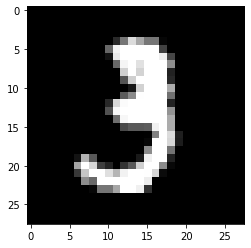

In [ ]:
(x_train, y_train), (X_test, y_test) = get_mnist_threes_nines()
display_image(x_train[2])

1.2a (finite differences checker, used to help implement `my_nn_finite_difference_checker` in 1.3a.

In [ ]:
def finite_difference_checker(f, x, k):
    """Returns \frac{\partial f}{\partial x_k}(x)"""
    epsilon = 0.00001
    x_plus = x
    x_minus = x
    x_minus[k] = x_minus[k] - epsilon
    x_plus[k] = x_plus[k] - epsilon
    derivative = f(x_plus) - f(x_minus) / (2*epsilon)
    return derivative

1.2b (functions that implement neural network layers)

In [ ]:
def sigmoid_activation(x):
    #for loop through x to do a sigmoid to it: 1/(1+np.exp(-x))
    # gradient of sigmoid: np.exp(-x)/(np.exp(-x)+1)**2
    overflow = 999
    out = np.array([(1/(1+np.exp(-val, where = np.where(
        np.sign(val) * val > overflow, False, True)))) for val in x])
    out[np.where(-x > overflow, True, False)] = 0
    out[np.where(x > overflow, True, False)] = 1
    #clip out
    out = np.clip(out, 10**-15, 1-(10**-15))
    #grad = np.array([(np.exp(-val)/(np.exp(-val)+1)**2) for val in x])
    grad = out * (1 - out)
    return out, grad

def logistic_loss(g, y):
    """
    Computes the loss and gradient for binary classification with logistic
    loss

    Inputs:
    - g: Output of final layer with sigmoid activation,
         of shape (n, 1)

    - y: Vector of labels, of shape (n,) where y[i] is the label for x[i]
         and y[i] in {0, 1}

    Returns a tuple of:
    - loss: array of losses
    - dL_dg: Gradient of the loss with respect to g
    """
    # log_loss = − log{g[i])^y[i](1 − g[i])^1−y[i])}
    y = y.reshape((-1,1))
    loss = -np.log(np.multiply(np.power(g, y), np.power(1-g, 1-y)))
    dL_dg = -(np.divide(y, g) - np.divide(1-y, 1-g))
    return loss, dL_dg

def relu_activation(s):
    out = np.maximum(s, 0)
    ds = np.where(s > 0, 1, 0)
    return out, ds

def layer_forward(x, W, b, activation_fn):
    # s = xW, s += b, out = g(s), cache = {s, out}
    s = x @ W
    s += b
    out, d_out = activation_fn(s)
    cache = (x, W, b, out, d_out, )
    return out, cache

1.3b i, ii (the sigmoid activation)

In [ ]:
# 1.3b i
s = np.asarray([1., 0., -1])
out, grad = sigmoid_activation(s)
with np.printoptions(precision=2):
    print(out)
    print(grad)
print("="*80)

# 1.3b ii
s = np.asarray([-1000., 1000.])
out, grad = sigmoid_activation(s)

print(out)
print(grad)
print("To get rid of the overflow I put a checker to see if the")
print("value of x was too high then set the output to 1 or if it")
print("was too low then set it to 0")

[0.73 0.5  0.27]
[0.2  0.25 0.2 ]
[1.e-15 1.e+00]
[1.00000000e-15 9.99200722e-16]
To get rid of the overflow I put a checker to see if the
value of x was too high then set the output to 1 or if it
was too low then set it to 0


1.2c (in this part if for functions that initialize the neural network's weights. I also code the forward pass which ties everything together, computing the output of a neural network with weights given by `weight_matrices` + `biases`, activation functions given by `activations`, on the input `X_batch`, a 2d input where each row is an individual input vector)

In [ ]:
def create_weight_matrices(layer_dims):
    """
    Creates a list of weight matrices defining the weights of NN

    Inputs:
    - layer_dims: A list whose size is the number of layers. layer_dims[i] defines
      the number of neurons in the i+1 layer.

    Returns a list of weight matrices
    """
    weights = []
    mu = 0
    sigma = 0.01
    for i in range (0, len(layer_dims) - 1):
      weights.append(np.random.normal(mu, sigma, (layer_dims[i], layer_dims[i+1])))
    return weights

def create_bias_vectors(layer_dims):
    biases = []
    for i in range(1, len(layer_dims)):
      biases.append(np.random.normal(0, 0.01, (1, layer_dims[i])))
    return biases

def forward_pass(X_batch, weight_matrices, biases, activations):
    output = X_batch
    layer_caches = []
    for i in range(0, len(weight_matrices)):
      output, cache = layer_forward(output, weight_matrices[i], biases[i], activations[i])
      layer_caches.append(cache)
    return output, layer_caches

1.3c (run a forward pass of the neural network and compute its logistic loss on some output)

In [ ]:
with open("test_batch_weights_biases.pkl", "rb") as fn:
    (X_batch, y_batch, weight_matrices, biases) = pickle.load(fn)

activations = [relu_activation, sigmoid_activation]
output, _ = forward_pass(X_batch, weight_matrices, biases,
                         activations)
loss, dL_dg = logistic_loss(output, y_batch)
print(loss.mean())

0.6985168038536878


1.3a (compute the gradient w.r.t. `weight_matrices` and `biases` using a finite differences checker)

In [ ]:
with open("test_batch_weights_biases.pkl", "rb") as fn:
    (X_batch, y_batch, weight_matrices, biases) = pickle.load(fn)

def my_nn_finite_difference_checker(X_batch, y_batch, weight_matrices, biases, activations):
    # Finite difference: for weights, biases
    epsilon = 1e-5
    grad_Ws = [np.zeros_like(weight_matrix) for weight_matrix in weight_matrices]
    for i in range(len(weight_matrices)):
      for j in range(weight_matrices[i].shape[0]):
        for k in range(weight_matrices[i][j].shape[0]):
          weight_matrices[i][j][k] += epsilon
          forward_pos = forward_pass(X_batch, weight_matrices, biases, activations)[0]
          weight_matrices[i][j][k] -= 2 *epsilon
          forward_neg = forward_pass(X_batch, weight_matrices, biases, activations)[0]
          weight_matrices[i][j][k] += epsilon
          forward_pos_loss = logistic_loss(np.squeeze(forward_pos), y_batch)[0]
          forward_neg_loss = logistic_loss(np.squeeze(forward_neg), y_batch)[0]
          grad_Ws[i][j][k] = (np.mean(forward_pos_loss) - np.mean(forward_neg_loss)) / (2*epsilon)

    grad_bs = [np.zeros_like(bias) for bias in biases]
    for i in range(len(biases)):
      for j in range(biases[i].shape[0]):
        for k in range(biases[i][j].shape[0]):
          biases[i][j][k] += epsilon
          forward_pos = forward_pass(X_batch, weight_matrices, biases, activations)[0]
          biases[i][j][k] -= 2 * epsilon
          forward_neg = forward_pass(X_batch, weight_matrices, biases, activations)[0]
          biases[i][j][k] += epsilon
          forward_pos_loss = logistic_loss(forward_pos, y_batch)[0]
          forward_neg_loss = logistic_loss(forward_neg, y_batch)[0]
          grad_bs[i][j][k] = (np.mean(forward_pos_loss) -
                              np.mean(forward_neg_loss)) / (2*epsilon)

    return grad_Ws, grad_bs

grad_Ws, grad_bs = my_nn_finite_difference_checker(X_batch,
                                                   y_batch,
                                                   weight_matrices,
                                                   biases,
                                                   activations)

with np.printoptions(precision=2):
    print(grad_Ws[0])
    print()
    print(grad_Ws[1])
    print()
    print(grad_bs[0])
    print()
    print(grad_bs[1])

[[ 4.12e-04  3.34e-05]
 [-6.56e-05  2.07e-05]
 [-1.24e-03  8.02e-05]
 [ 2.26e-04 -1.41e-06]]

[[-0.  ]
 [-0.01]]

[[-0.  0.]]

[[-0.5]]


1.2d (the backward pass)

In [ ]:
def backward_pass(dL_dg, layer_caches):
    grad_Ws = [np.zeros_like(weight_matrix) for weight_matrix in weight_matrices]
    grad_bs = [np.zeros_like(bias) for bias in biases]
    sum_del = dL_dg
    mini_batch = dL_dg.shape[0]
    #base case:
    for l in range(len(layer_caches) - 1, -1, -1):
      #read from layer cache
      x, W, b, out, d_out = layer_caches[l]
      del_s = sum_del * d_out
      dL_dw = np.dot(x.T, del_s)
      grad_Ws[l] = dL_dw / mini_batch
      sum_del = np.dot(del_s,  W.T)
      grad_bs[l] = np.mean(del_s, axis = 0).reshape((1, -1))
    return grad_Ws, grad_bs

1.3d (test the backward pass! compare it with 1.3a, the gradient computed by the finite difference checker. The answers should match!)

In [ ]:
with open("test_batch_weights_biases.pkl", "rb") as fn:
    (X_batch, y_batch, weight_matrices, biases) = pickle.load(fn)

activations = [relu_activation, sigmoid_activation]
output, layer_caches = forward_pass(X_batch, weight_matrices, biases,
                                    activations)
loss, dL_dg = logistic_loss(output, y_batch)
grad_Ws, grad_bs = backward_pass(dL_dg, layer_caches)

with np.printoptions(precision=2):
    print(grad_Ws[0])
    print()
    print(grad_Ws[1])
    print()
    print(grad_bs[0])
    print()
    print(grad_bs[1])



[[ 4.12e-04  3.34e-05]
 [-6.56e-05  2.07e-05]
 [-1.24e-03  8.02e-05]
 [ 2.26e-04 -1.41e-06]]

[[-0.  ]
 [-0.01]]

[[-0.  0.]]

[[-0.5]]


1.2e (train the neural network on MNIST! save the training and test losses and accuracies at each iteration to use in 1.3e)

In [ ]:
(X_train, y_train), (X_test, y_test) = get_mnist_threes_nines()
print(X_train.shape)
X_train = X_train.reshape(12080, 28*28)
X_test = X_test.reshape(2019, 28*28)
y_train_stack = [[y] for y in y_train]
#y_test_stack = [[y] for y in y_test]
batch_size = 100
step_size = .1

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
misclassified = {}

layers = [784, 200, 1]
activations = [relu_activation, sigmoid_activation]
weights = create_weight_matrices(layers)
biases = create_bias_vectors(layers)


for i in range(5):
  train_w_y = np.hstack((X_train, y_train_stack))
  np.random.shuffle(train_w_y)
  x_batch = np.delete(train_w_y, -1, axis=1)
  y_batch = train_w_y[:, -1]
  x_batch_split = np.array_split(x_batch, batch_size)
  y_batch_split = np.array_split(y_batch, batch_size)

  for j in range(batch_size):
    totalCorrect = 0
    totalPredictions = 0
    output_test, cache = forward_pass(X_test, weights, biases, activations)
    loss_test, d_loss_train = logistic_loss(output_test, y_test)
    loss_test = loss_test.mean()
    test_loss.append(loss_test)
    for val in range(output_test.shape[0]):
      totalPredictions += 1
      if output_test[val] > 0.5:
        if y_test[val] == 1:
          totalCorrect += 1
        else:
          misclassified[val + (i * batch_size)] = output_test[val]
      else:
        if y_test[val] == 0:
          totalCorrect += 1
        else:
          misclassified[val + (i * batch_size)] = output_test[val]
    test_accuracy.append(totalCorrect / totalPredictions)

    output, layer_cache = forward_pass(x_batch_split[j], weights, biases, activations)
    loss_train, dL_dg = logistic_loss(output, y_batch_split[j])
    loss_train = loss_train.mean()
    train_loss.append(loss_train)

    totalPredictions = 0
    totalCorrect = 0

    for val in range(output.shape[0]):
      totalPredictions += 1
      if output[val] > 0.5:
        if y_batch_split[j][val] == 1:
          totalCorrect += 1
      else:
        if y_batch_split[j][val] == 0:
          totalCorrect += 1
    train_accuracy.append(totalCorrect / totalPredictions)

    grad_Ws, grad_bs = backward_pass(dL_dg, layer_cache)
    for w in range(len(weights)):
      weights[w] = weights[w] - (step_size * grad_Ws[w])
      biases[w] = biases[w] - (step_size * grad_bs[w])


(12080, 28, 28)


1.3e code answers for i, ii, iii

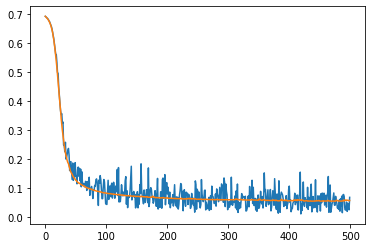

In [ ]:
# i
# Plot the train and test losses from the MNIST network with step size = 0.1
#print(test_loss)
plt.plot(train_loss)
plt.plot(test_loss)

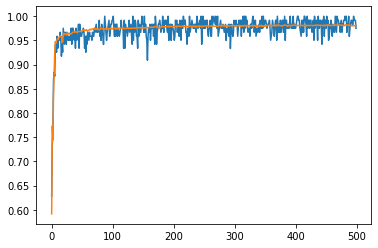

In [ ]:
# ii
# Plot the train and test accuracies from the MNIST network with step size = 0.1
plt.plot(train_accuracy)
plt.plot(test_accuracy)

[0.52131257]
[0.50405716]
[0.51298292]


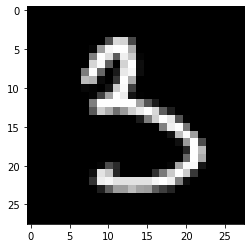

In [ ]:
# iii
# Visualize (plot) some images that are misclassified by your network
index, output_val = list(misclassified.items())[-1]
display_image(x_train[index])
print(output_val)
index, output_val = list(misclassified.items())[-2]
display_image(x_train[index])
print(output_val)
index, output_val = list(misclassified.items())[-3]
display_image(x_train[index])
print(output_val)